In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC

import lifelines

In [2]:
# reading dataset from CSV file
cc_df = pd.read_csv("../data/UCI_Credit_Card.csv")

In [3]:
pd.DataFrame(cc_df["default.payment.next.month"].value_counts())
new_df = cc_df.rename(columns={"default.payment.next.month":'default'})



In [4]:
pd.DataFrame(new_df["default"].value_counts())

,default
0,23364
1,6636


In [5]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [6]:
categorical_feats = [
    'PAY_0',
    'PAY_2',
    'PAY_3',
    'PAY_4',
    'PAY_5',
    'PAY_6',
    'MARRIAGE',
    'EDUCATION'
]

numeric_feats = [
    'LIMIT_BAL',
    'AGE',
    'BILL_AMT1',
    'BILL_AMT2',
    'BILL_AMT3',
    'BILL_AMT4',
    'BILL_AMT5',
    'BILL_AMT6',
    'PAY_AMT1',
    'PAY_AMT2',
    'PAY_AMT3',
    'PAY_AMT4',
    'PAY_AMT5',
    'PAY_AMT6',
    'SEX'
]

target_column = ['default']

In [16]:
preprocessing_final = make_column_transformer(
    (
        FunctionTransformer(lambda x: x == 1),
        target_column,
    ),  # because we need it in this format for lifelines package
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_feats),
)


In [17]:
train_df, test_df = train_test_split(new_df, random_state=123)

In [18]:
preprocessing_final.fit(train_df)

ColumnTransformer(transformers=[('functiontransformer',
                                 FunctionTransformer(func=<function <lambda> at 0x000002286C75F700>),
                                 ['default']),
                                ('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6', 'SEX']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6', 'MARRIAGE', 'EDUCATION'])])

In [19]:
new_columns = (
    target_column
    + numeric_feats
    + preprocessing_final.named_transformers_["onehotencoder"]
    .get_feature_names(categorical_feats)
    .tolist()
)

In [20]:

train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

In [21]:
train_df_surv['default'].value_counts()

0.0    17491
1.0     5009
Name: default, dtype: int64

In [23]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(train_df_surv["PAY_AMT1"], train_df_surv["default"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 22500 total observations, 17491 right-censored observations>

Text(0, 0.5, 'Survival probability')

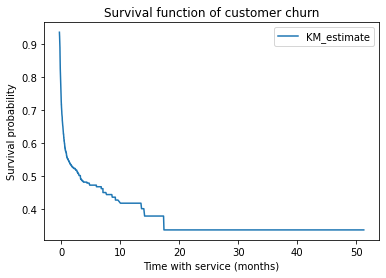

In [24]:
kmf.survival_function_.plot()
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability")

In [25]:
np.mean(train_df_surv.query("default == 1.0")["AGE"])

0.02717948056069568